In [3]:
import os 

# Limit GPU consumption
DEVICE = '2'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = DEVICE

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # add this
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import jax
import jax.numpy as jnp
import numpy as np

import haiku as hk
import optax

import matplotlib.pyplot as plt

import importlib
import sys

import wandb
import cellpylib as cpl

import model
import dataloader
# from model import network_fn, logit_to_preds
# from dataloader import make_game_of_life
importlib.reload(sys.modules['model'])
importlib.reload(sys.modules['dataloader'])
from model import network_fn, logit_to_preds
from dataloader import make_game_of_life, dataloader

wandb.login()

True

In [5]:
## Training cell

from typing import NamedTuple
from tqdm import tqdm

## Create some globals at first

try:
    del transform
except:
    ...
    
# Create the pure network transformation
transform = hk.without_apply_rng(hk.transform(network_fn))

# Create the optimizer
learning_rate = 1e-2
wandb.config['learning_rate'] = learning_rate
optimizer = optax.adam(learning_rate)

class TrainState(NamedTuple):
    params: hk.Params
    opt_state: optax.OptState

class Batch(NamedTuple):
    input_states: np.ndarray  # [B, H, W, 1]
    output_states: np.ndarray  # [B, H, W, 1]

# First make an init function to initialize params and opt state
def init() -> TrainState:
    """Initialize params and optimizer state
    """
    print("Initializing model")

    # First make a batch of data using X_train and Y_train globals
    # Add a singleton dimension to each dataset
    batch = Batch(np.array(X_train[..., np.newaxis]), 
                  np.array(Y_train[..., np.newaxis]))

    # Initialize params and optimizer state
    params = transform.init(rng, batch.input_states, layer_dims)
    opt_state = optimizer.init(params)

    return TrainState(params, opt_state), batch

@jax.jit
def loss_fn(params: hk.Params, batch: Batch) -> jax.Array:
    """Loss function
    """
    # Constructs a one-hot encoding of the true output states
    true_output_states = jnp.squeeze(jax.nn.one_hot(batch.output_states, 
                                                    num_classes))
    labels = np.reshape(true_output_states, newshape=(-1, num_classes))

    # Get the output of the model and convert the shapes
    network_output = transform.apply(params, batch.input_states, layer_dims)    
    logits = np.reshape(network_output, newshape=(-1, num_classes))
    
    loss = optax.softmax_cross_entropy(logits=logits, labels=labels)
    loss = jnp.mean(loss)

    return loss, (loss, network_output)

@jax.jit
def update(state: TrainState, batch: Batch) -> TrainState:
    """Implement the learning rule
    """
    # Take gradients first
    grads, (loss, network_output) = jax.grad(loss_fn, has_aux=True)(state.params, batch)

    # Pass grads through optimizer
    updates, opt_state = optimizer.update(grads, state.opt_state)
    params = optax.apply_updates(state.params, updates)

    return TrainState(params, opt_state), (loss, network_output)
    
def train(state: TrainState, batch: Batch, epochs,
          print_every=50, log_every=50
         ):

    columns = ["Input state", "Network Prediction", "Expected Output", "Epoch"]
    # columns = ["Visualizations", "Epoch"]
    table = wandb.Table(columns=columns)
             
    for epoch in tqdm(range(epochs)):
        state, (loss, network_output) = update(state, batch)

        run.log({
            "epoch": epoch,
            "loss": loss
        })

        if epoch % print_every == 0:
            print(f"loss at epoch {epoch}: {loss:.8f}")

        if epoch % log_every == 0:
            preds = logit_to_preds(network_output, shape=(-1, wspan, hspan)) 

            # Log images to the table
            table.add_data(
                wandb.Image(plt.imshow(batch.input_states[0], cmap='gray')),
                wandb.Image(plt.imshow(preds[0], cmap='gray')),
                wandb.Image(plt.imshow(batch.output_states[0], cmap='gray')),
                epoch
            )
            plt.close()
  
    run.log({"network_predictions": table})

    return state, loss

# Add number of epochs to the config
epochs = 101
run.config['epochs'] = epochs

state, batch = init()
state, final_loss = train(state, batch, epochs=epochs, log_every=5)

Error: You must call wandb.init() before wandb.config['learning_rate']

In [7]:
state

NameError: name 'state' is not defined

In [5]:
def apply_network(state: TrainState, input_states: np.ndarray, 
                return_logits=False) -> jax.Array:
    """Use the global `transform` and passed-in state to 
        get a network output from `input_states`.

        :param return_logits: bool, whether the function should just 
        return the network logits or convert to predictions
    """
    logits = transform.apply(state.params, input_states, layer_dims)
    preds = logit_to_preds(logits, shape=(-1, wspan, hspan))   
    if return_logits:
        return logits, preds
    else:
        return preds

def evaluate(state: TrainState, batch: Batch) -> jax.Array:
    """Get model outputs and evaluate model performance on a batch
        of data

        Note: By default, the output of the network has shape
        [B, H*W, num_classes], we want to reshape the labels 
        to have this shape.
    """
    # Get one-hot-encodings of the expected output
    # and convert to labels
    true_output_states = jnp.squeeze(jax.nn.one_hot(batch.output_states, 
                                                    num_classes)) 
    labels = np.reshape(true_output_states, newshape=(-1, 
                                                      wspan*hspan,
                                                      num_classes))
    # Get network logits
    logits, preds = apply_network(state, batch.input_states, return_logits=True)
    print(logits.shape)
    
    # Compute the loss 
    loss = optax.softmax_cross_entropy(logits=logits, labels=labels) 

    return jnp.mean(loss, axis=1), preds

losses, preds = evaluate(state, batch)
preds.shape, losses.shape

(500, 400, 2)


((500, 20, 20), (500,))

In [6]:
type(preds[0])
type(batch.input_states[0])

numpy.ndarray

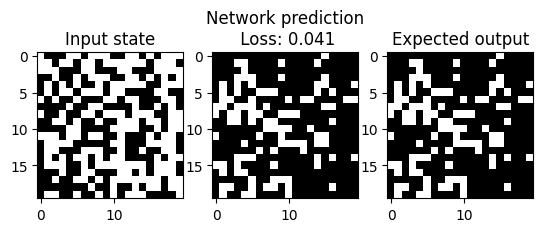

In [7]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
ind = 54
ax0.imshow(batch.input_states[ind], cmap='gray')
ax1.imshow(preds[ind], cmap='gray')
ax2.imshow(batch.output_states[ind], cmap='gray')

ax0.set_title("Input state")
ax1.set_title(f"Network prediction\n Loss: {losses[ind]:.3f}")
ax2.set_title("Expected output")

fig.show()


<module 'matplotlib.pyplot' from '/home/sradev/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

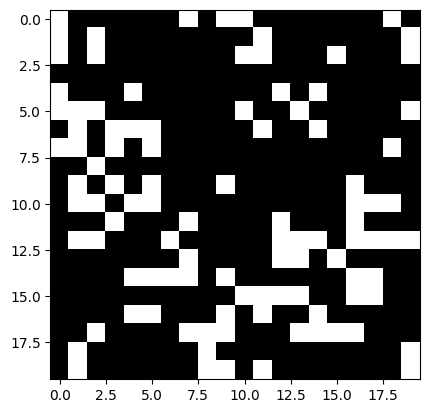

In [86]:
one = plt.imshow(batch.input_states[ind], cmap='gray')
two = plt.imshow(preds[ind], cmap='gray')
three = plt.imshow(batch.output_states[ind], cmap='gray')

In [92]:
columns = ["Input state", "Net pred", "Exp pred"]
table = wandb.Table(columns=columns)
table.add_data(wandb.Image(plt.imshow(batch.input_states[ind], cmap='gray')),
               wandb.Image(plt.imshow(preds[ind], cmap='gray')),
               wandb.Image(plt.imshow(batch.output_states[ind], cmap='gray'))
              )
plt.close()
run.log({"test_table1": table})

# table.add_data(wandb.Image(input_state),
#                wandb.Image(np.array(preds[0])),
#                wandb.Image(batch.output_states[0]),
#                # plt,
#                epoch
#               )    


In [93]:
run

In [94]:
logits, _ = apply_network(state, batch.input_states, return_logits=True)

In [9]:
run.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,███▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.06449


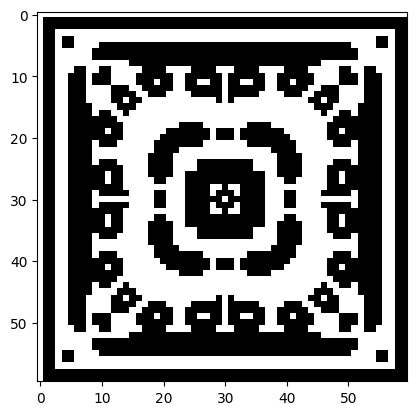

In [111]:
import cellpylib as cpl

# initialize a 60x60 2D cellular automaton
cellular_automaton = cpl.init_simple2d(60, 60)

# evolve the cellular automaton for 30 time steps,
#  applying totalistic rule 126 to each cell with a Moore neighbourhood
cellular_automaton = cpl.evolve2d(cellular_automaton, timesteps=30, neighbourhood='Moore',
                                  apply_rule=lambda n, c, t: cpl.totalistic_rule(n, k=2, rule=126))

cpl.plot2d(cellular_automaton)

In [8]:
cellular_automaton = cpl.init_random(200)

cellular_automaton = cpl.evolve(cellular_automaton, timesteps=1000,
                                apply_rule=lambda n, c, t: cpl.nks_rule(n, 30))

# calculate the average cell entropy; the value will be ~0.999 in this case
avg_cell_entropy = cpl.average_cell_entropy(cellular_automaton)
